# Quantum - Portfilio Optimization

In [1]:
from qiskit import Aer 
from qiskit.utils import QuantumInstance 
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer, GroverOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit.utils import algorithm_globals 
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA


In [2]:
num_assets = 4

# generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks, start=datetime.datetime(2017,1,1), end=datetime.datetime(2017,1,30))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

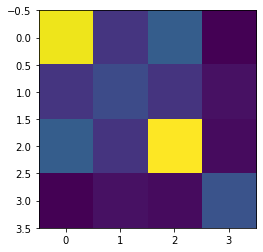

In [3]:
# plot sigma 
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [4]:
q = 0.5 # set risk factor 
budget = num_assets // 2 # set budget 
penalty = num_assets # set parameter to scale the budget penalty term 

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: 0.005765819839 x_0 + 0.005395065308 x_1 - 0.002132413178 x_2
      + 0.005167838159 x_3 + [ 0.005826040932 x_0^2 + 0.000599326310 x_0*x_1
      + 0.002482190903 x_0*x_2 - 0.001470975435 x_0*x_3 + 0.000809832761 x_1^2
      + 0.000577100332 x_1*x_2 - 0.000859674787 x_1*x_3 + 0.006007556415 x_2^2
      - 0.001063180384 x_2*x_3 + 0.000997821386 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_results(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probablities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probablities))
    print('\n--------------Full result------------------')
    print('selection\tvalue\t\tprobablity')
    print('---------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probablity = probablities[i]
        print('%10s\t%.4f\t\t%.4f' % (x, value, probablity))

## Classical Optimization Solver 

In [6]:
classicalSolver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = classicalSolver.solve(qp)
print_results(result)

Optimal: selection [0. 0. 1. 1.], value 0.0060

--------------Full result------------------
selection	value		probablity
---------------------------------------------
 [0 0 1 1]	0.0060		1.0000
 [1 1 1 1]	4.1364		0.0000
 [0 1 1 1]	1.0405		0.0000
 [1 0 1 1]	1.0440		0.0000
 [1 1 0 1]	1.0481		0.0000
 [0 1 0 1]	0.0110		0.0000
 [1 0 0 1]	0.0136		0.0000
 [0 0 0 1]	1.0345		0.0000
 [1 1 1 0]	1.0460		0.0000
 [0 1 1 0]	0.0070		0.0000
 [1 0 1 0]	0.0108		0.0000
 [0 0 1 0]	1.0297		0.0000
 [1 1 0 0]	0.0148		0.0000
 [0 1 0 0]	1.0346		0.0000
 [1 0 0 0]	1.0375		0.0000
 [0 0 0 0]	4.1152		0.0000


## Check if VQE agrees with classical solver  

In [ ]:
seed = 10598
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(num_assets, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
vqeSolver = MinimumEigenOptimizer(vqe)
result = vqeSolver.solve(qp)

# print results 
print_results(result)   # col 1 in wrong order

Optimal: selection [0. 0. 1. 1.], value 0.0060

--------------Full result------------------
selection	value		probablity
---------------------------------------------
 [1 0 0 1]	0.0136		0.3694
 [0 1 0 1]	0.0110		0.3422
 [0 1 1 0]	0.0070		0.2883
 [1 0 1 0]	0.0108		0.0000
 [1 1 1 1]	4.1364		0.0000
 [0 0 1 1]	0.0060		0.0000
 [0 0 0 0]	4.1152		0.0000
 [1 0 0 0]	1.0375		0.0000
 [1 1 0 1]	1.0481		0.0000
 [0 1 0 0]	1.0346		0.0000
 [0 1 1 1]	1.0405		0.0000
 [0 0 1 0]	1.0297		0.0000
 [0 0 0 1]	1.0345		0.0000
 [1 1 1 0]	1.0460		0.0000
 [1 0 1 1]	1.0440		0.0000
 [1 1 0 0]	0.0148		0.0000


## Check if Grover agrees with classical solver  

In [8]:
grover_optimizer = GroverOptimizer(num_assets*2, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
results

optimal function value: 0.006006523690045078
optimal value: [0. 0. 1. 1.]
status: SUCCESS

In [9]:
results.x

array([0., 0., 1., 1.])